# 0.- **Warnings**

This notebook cannot be run as it is. It makes use of downloaded data that might be later specified where and how to get the data. If not found, write to a maintainer to get directions

# 1.- Imports

In [1]:
# Module import
import sys
import pandas as pd
# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')

# local imports
import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source
import constants as const
from agis import Agis
from agis import Calc_source
from agis_functions import *


from analytic_plots import *

import matplotlib
import time
from scipy import sparse as sps
import pickle
from tqdm import trange

from astroquery.gaia import Gaia

import warnings
warnings.filterwarnings('ignore')

DATA_FOLDER = '../../data/'
ARCHIVE_FOLDER = DATA_FOLDER+'gaia_archives_data/'
PICKLE_FOLDER = DATA_FOLDER+'pickle_data/'
FIG_FOLDER = '../figures/'

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


# 2.- Satellite and scanner:

In [2]:
t_init = 0 
t_end =  t_init + 365
my_dt = 1/24/4 # [days]

# objects
spline_degree = 3
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_degree)

In [3]:
double_telescope = True
my_scanner = Scanner(zeta_limit=np.radians(0.5) ,double_telescope=double_telescope) 

# 3.- Get sources from gaia-archives

Do the query to gaia archive:

### 3.1 Query

In [4]:
str_query = "SELECT \
    TOP 10 source_id,random_index,ra,dec,parallax,pmra,pmdec,radial_velocity \
    FROM gaiadr2.gaia_source \
    WHERE parallax_over_error>10 \
        AND radial_velocity<1000\
        AND visibility_periods_used>8 \
        AND astrometric_excess_noise<1 \
    ORDER BY random_index;"

job = Gaia.launch_job_async(str_query);
r = job.get_results()
df = r.to_pandas()

Query finished.


In [5]:

df.head()

,source_id,random_index,ra,dec,parallax,pmra,pmdec,radial_velocity
0,5945654653855118976,1077,267.457614,-51.241629,0.590209,-2.561638,-5.680921,-5.695978
1,2907611259311229568,1205,84.517262,-27.720603,2.331639,-0.747300,19.999349,108.246933
2,1141434876568787584,1340,94.423445,79.702193,0.790480,0.974301,0.824754,-37.580879
3,4187550129570302080,1626,291.078568,-12.019174,1.022314,-3.816536,-2.060647,-18.132887
4,2217219730615749120,1640,321.670835,63.290820,0.753490,-1.670066,-2.527116,-13.702765


### 3.2 Visualize in sky

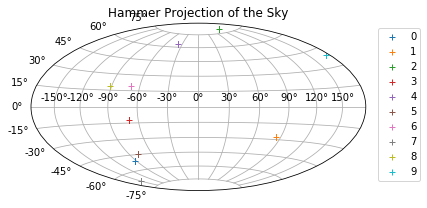

In [6]:
sources = []
for i in df.index:
    sources.append(Source(str(i),df['ra'][i], df['dec'][i], df['parallax'][i],
                          df['pmra'][i], df['pmdec'][i], df['radial_velocity'][i]))
plot_sources_in_sky(sources)

# 4.- Scan all sources

In [7]:
obs_times = []
calc_sources = []
real_sources = []

# scan the sources and keep as real sources only the ones that are observed
for i in trange(len(sources)):
    s = sources[i]
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    if len(my_scanner.obs_times)>0:
        obs_times += my_scanner.obs_times
        real_sources.append(s)
        calc_sources.append(Calc_source(obs_times=my_scanner.obs_times.copy(), source=s))
sources = real_sources
obs_times = list(np.sort(obs_times))

100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


In [8]:
# Add noise to the sources
noise = np.random.rand(5)*const.rad_per_mas*5
noise[2] += 20*const.rad_per_mas
for s in calc_sources:
    add_noise_to_calc_source(s, noise)

# 5.- Source update

In [9]:
Solver = Agis(gaia, calc_sources, sources, updating='scanned source', double_telescope=True)

In [10]:
Solver.reset_iterations()
Solver.iterate(7, verbosity=1)

Not resetting everything! Call again the solver instead
***** Iteration: 1 *****
Error after iteration: 1.609471479380397e-12
***** Iteration: 2 *****
Error after iteration: 4.0803382280371493e-13
***** Iteration: 3 *****
Error after iteration: 5.054927321032259e-14
***** Iteration: 4 *****
Error after iteration: 4.67160438070272e-15
***** Iteration: 5 *****
Error after iteration: 3.6500970456142937e-16
***** Iteration: 6 *****
Error after iteration: 2.5403347054108917e-17
***** Iteration: 7 *****
Error after iteration: 1.618237714423037e-18


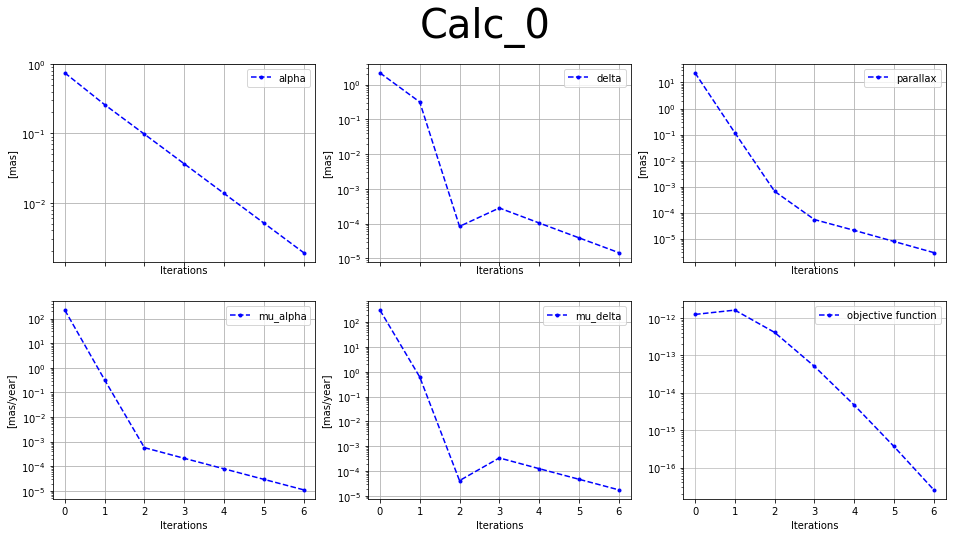

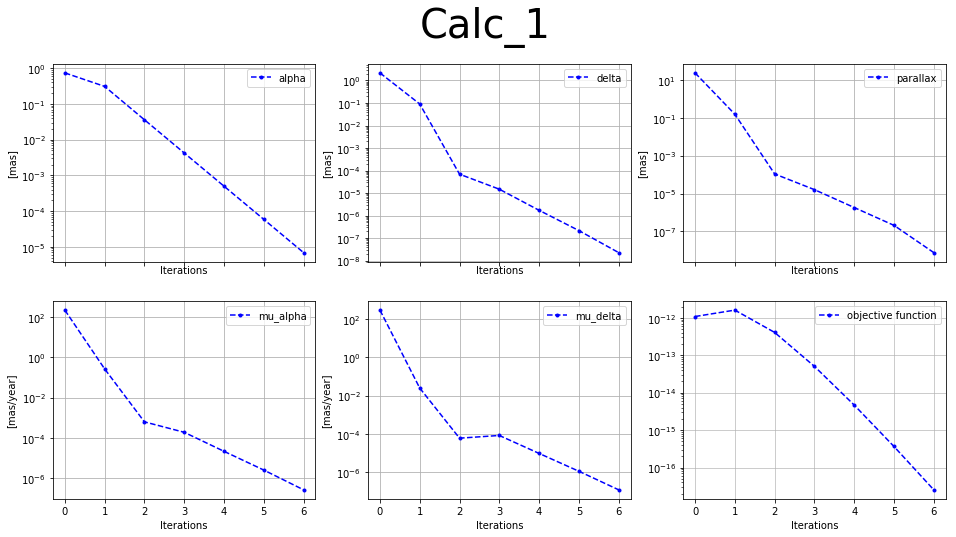

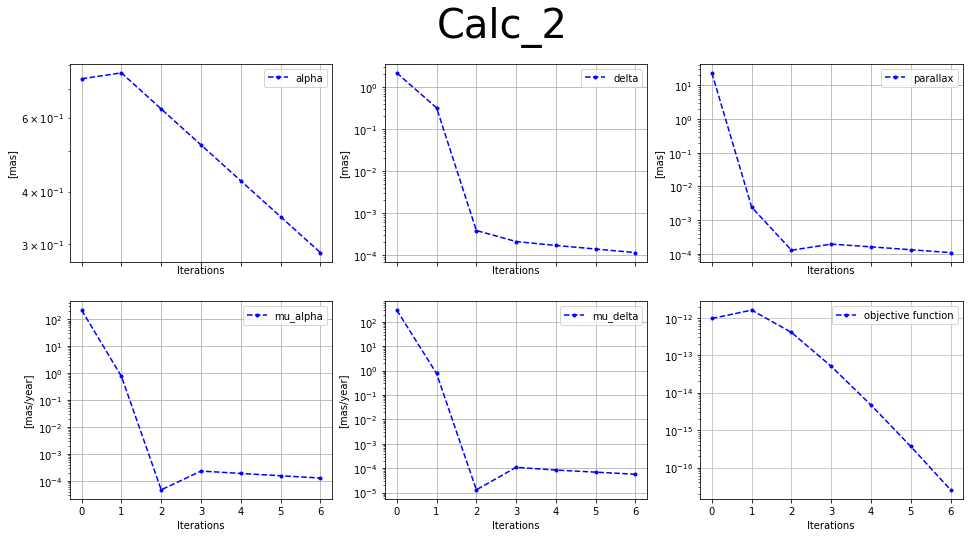

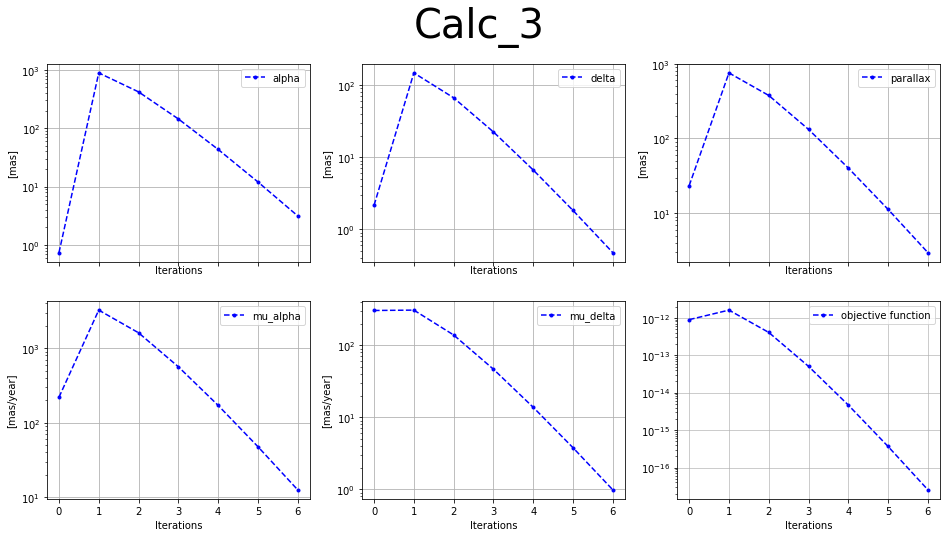

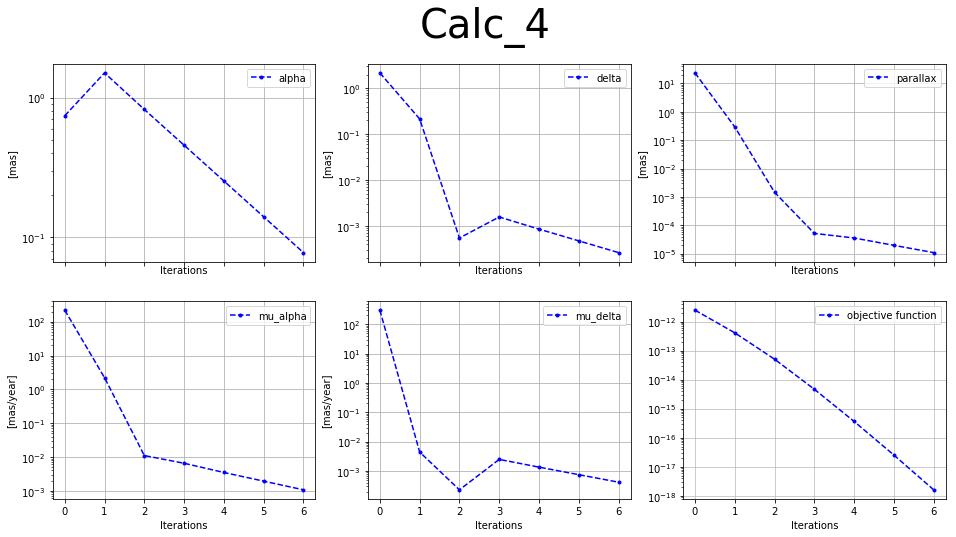

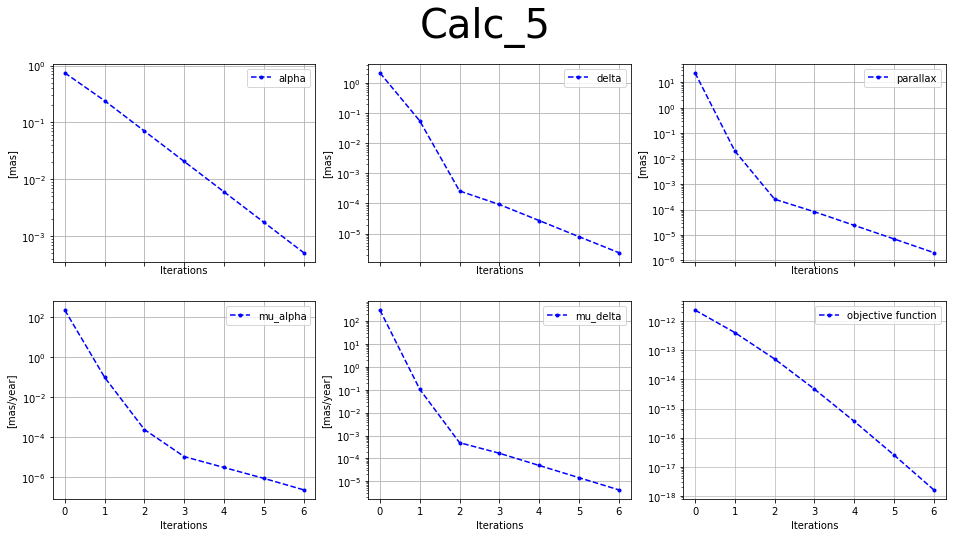

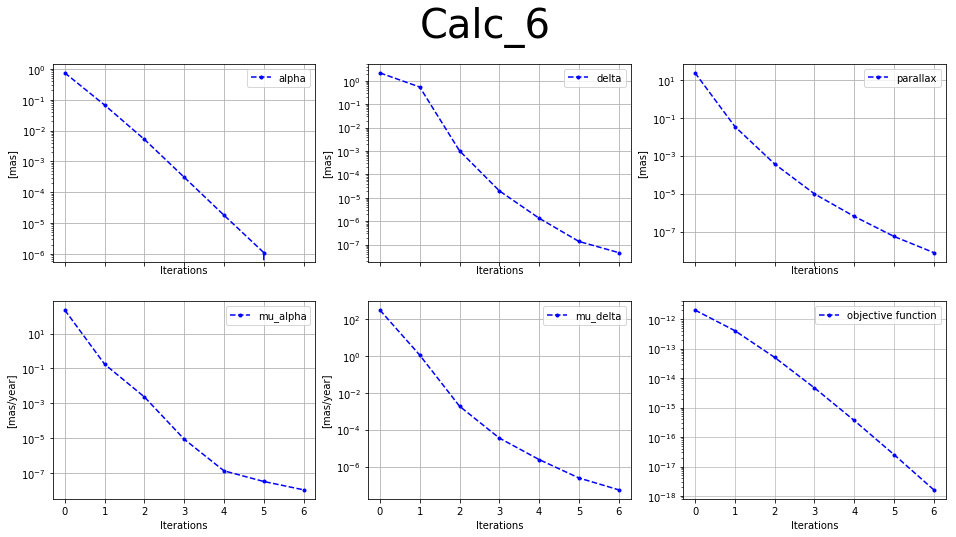

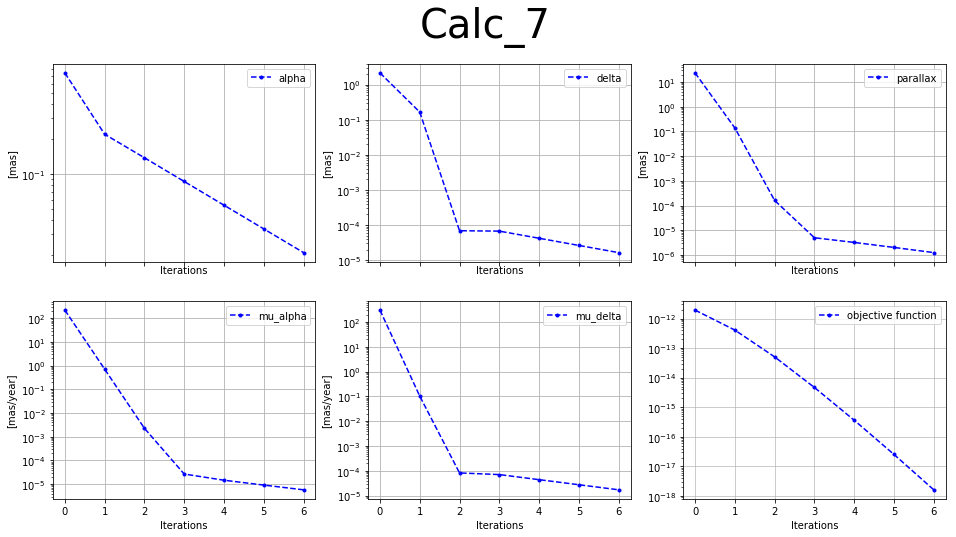

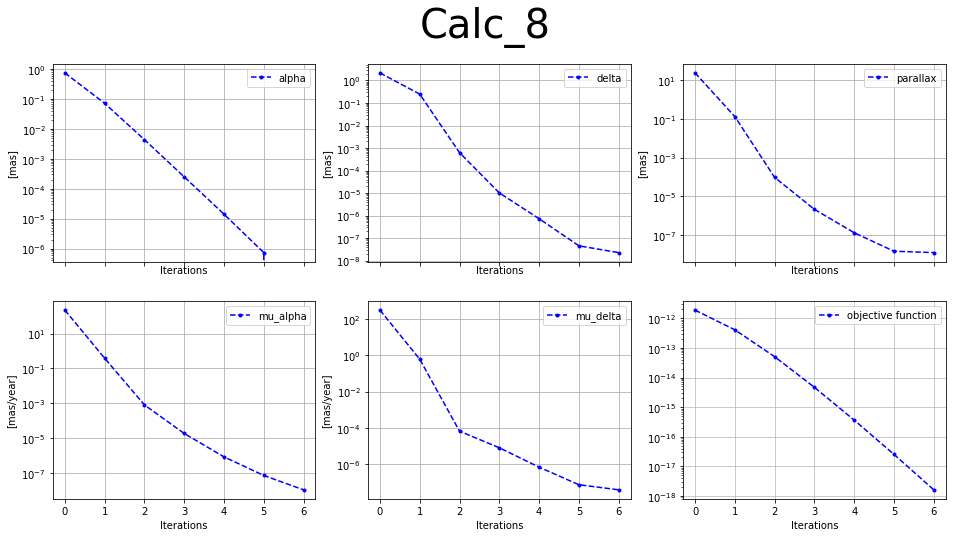

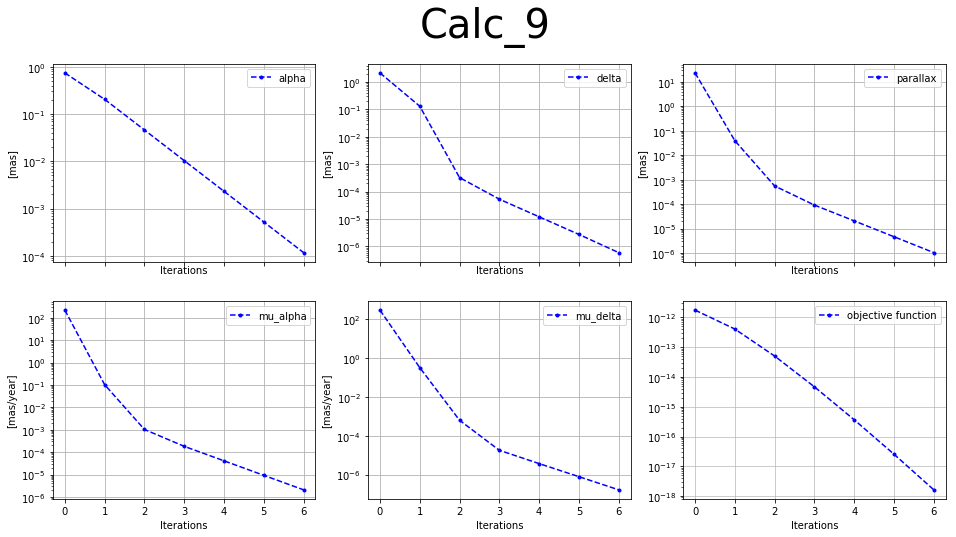

In [11]:
figs = plot_errors_VS_iterations_per_source(Solver);